# HW 4 - Real Time Machine Learning
Jacob Barker - 801075553

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras_flops import get_flops

2023-03-29 17:45:03.500789: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-29 17:45:04.133881: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/jacob/miniconda3/envs/tf/lib/
2023-03-29 17:45:04.133950: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/jacob/miniconda3/envs/tf/lib/
2023-03-29 17:45:04.133956: W tensorflow/compiler/tf2ten

In [2]:
# Load the text file for time machine dataset
with open("/home/jacob/Downloads/timemachine.txt", "r") as f:
    text = f.read()

# Create a dictionary to map characters to integers
chars = sorted(list(set(text)))
char_to_int = {c: i for i, c in enumerate(chars)}
int_to_char = {i: c for i, c in enumerate(chars)}
print(char_to_int)
# Convert the text to a sequence of integers
seq_length = 100
data = []
for i in range(0, len(text) - seq_length, 1):
    seq_in = text[i:i + seq_length]
    seq_out = text[i + seq_length]
    data.append((np.array([char_to_int[c] for c in seq_in]), char_to_int[seq_out]))

# Split the data into training and validation sets
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
val_data = data[train_size:]

{'\n': 0, ' ': 1, '!': 2, '"': 3, '#': 4, '$': 5, '%': 6, "'": 7, '(': 8, ')': 9, '*': 10, ',': 11, '-': 12, '.': 13, '/': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, ';': 26, '?': 27, 'A': 28, 'B': 29, 'C': 30, 'D': 31, 'E': 32, 'F': 33, 'G': 34, 'H': 35, 'I': 36, 'J': 37, 'K': 38, 'L': 39, 'M': 40, 'N': 41, 'O': 42, 'P': 43, 'Q': 44, 'R': 45, 'S': 46, 'T': 47, 'U': 48, 'V': 49, 'W': 50, 'X': 51, 'Y': 52, '[': 53, ']': 54, '_': 55, 'a': 56, 'b': 57, 'c': 58, 'd': 59, 'e': 60, 'f': 61, 'g': 62, 'h': 63, 'i': 64, 'j': 65, 'k': 66, 'l': 67, 'm': 68, 'n': 69, 'o': 70, 'p': 71, 'q': 72, 'r': 73, 's': 74, 't': 75, 'u': 76, 'v': 77, 'w': 78, 'x': 79, 'y': 80, 'z': 81, 'æ': 82, 'ç': 83, 'ü': 84, 'œ': 85, '—': 86, '‘': 87, '’': 88, '“': 89, '”': 90, '…': 91}


1a) Use the GRU example, adjust the hyperparameters (fully connected network and the number of hidden states) and analyze their influence on running time, perplexity, training and validation loss, and the output sequence (try a few examples).

In [3]:
def gru(num_states, batch_size, epochs):
    # Define the GRU model
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(len(chars), 32),
        tf.keras.layers.GRU(num_states),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(len(chars), activation='sigmoid')
    ])

    # Compile the model
    model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  metrics=["accuracy"])
    history = model.fit(
        np.array([x[0] for x in train_data]),
        np.array([x[1] for x in train_data]),
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(
            np.array([x[0] for x in val_data]),
            np.array([x[1] for x in val_data])))
    
    #Plotting Train and Val loss
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['loss'])
    plt.title('GRU Model Loss')
    plt.xlabel('epochs')
    plt.legend(['val_loss', 'train_loss'], loc = 'upper left')
    plt.show()
    
    #Plotting Train, Val Perplexity
    plt.plot(tf.exp(history.history['val_loss']))
    plt.plot(tf.exp(history.history['loss']))
    plt.title('GRU Model Perplexity')
    plt.xlabel('epochs')
    plt.legend(['val_ppl', 'train_ppl'], loc = 'upper left')
    plt.show()
    
    # Generate text using the trained model
    generated_text = ""
    seed = "it has" #Seed to give to model to predict the next 50 characters
    sequence = []
    for char in seed:
        sequence = sequence + [char_to_int[char]]
    for i in range(50):
        x = np.reshape(sequence, (1, len(sequence)))
        prediction = model.predict(x, verbose=0)
        index = np.argmax(prediction)
        result = int_to_char[index]
        generated_text += result
        sequence = np.append(sequence[1:], index)

    print(generated_text)
    
    #Getting Model Complexity and size
    flops = get_flops(model, batch_size=1)
    print(f"FLOPS: {flops / 10 ** 9:.03} G")
    model.summary()
    
    

2023-03-29 17:45:13.020422: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 17:45:13.046908: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 17:45:13.047273: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 17:45:13.047846: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Epoch 1/30


2023-03-29 17:45:15.833916: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-29 17:45:16.512179: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x294a4a50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-29 17:45:16.512199: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2023-03-29 17:45:16.515822: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-29 17:45:16.607641: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


78/78 [==============================] - 6s 35ms/step - loss: 3.5023 - accuracy: 0.1630 - val_loss: 3.1808 - val_accuracy: 0.1574
Epoch 2/30
78/78 [==============================] - 1s 16ms/step - loss: 2.9476 - accuracy: 0.1903 - val_loss: 2.9499 - val_accuracy: 0.2212
Epoch 3/30
78/78 [==============================] - 1s 18ms/step - loss: 2.5965 - accuracy: 0.2802 - val_loss: 2.7588 - val_accuracy: 0.2694
Epoch 4/30
78/78 [==============================] - 1s 16ms/step - loss: 2.4204 - accuracy: 0.3074 - val_loss: 2.6711 - val_accuracy: 0.2862
Epoch 5/30
78/78 [==============================] - 1s 16ms/step - loss: 2.3266 - accuracy: 0.3300 - val_loss: 2.6191 - val_accuracy: 0.3123
Epoch 6/30
78/78 [==============================] - 1s 16ms/step - loss: 2.2630 - accuracy: 0.3458 - val_loss: 2.5757 - val_accuracy: 0.3139
Epoch 7/30
78/78 [==============================] - 1s 16ms/step - loss: 2.2058 - accuracy: 0.3568 - val_loss: 2.5317 - val_accuracy: 0.3259
Epoch 8/30
78/78 [======

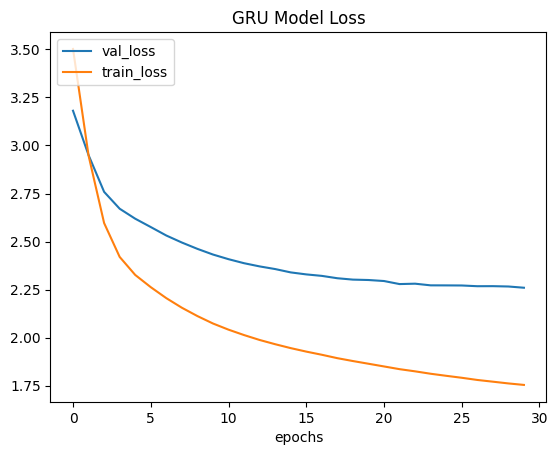

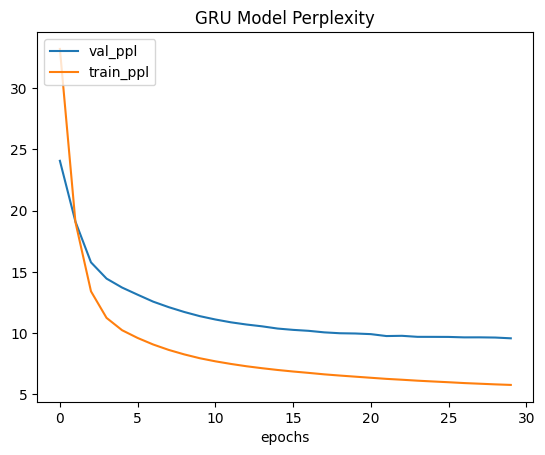

 the strang the strang the strang the strang the s
Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report=========

2023-03-29 17:45:58.830915: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 17:45:58.831230: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-03-29 17:45:58.831310: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-29 17:45:58.831679: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 17:45:58.831978: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 17:45:58.832256: I tensorflow/compiler/x

In [4]:
# Train the gru model
batch_size = 2048
epochs = 30
num_states = 32
gru(num_states, batch_size, epochs)

Epoch 1/30
78/78 [==============================] - 5s 39ms/step - loss: 3.4246 - accuracy: 0.1552 - val_loss: 3.1785 - val_accuracy: 0.1574
Epoch 2/30
78/78 [==============================] - 2s 26ms/step - loss: 2.8780 - accuracy: 0.2146 - val_loss: 2.8494 - val_accuracy: 0.2553
Epoch 3/30
78/78 [==============================] - 2s 26ms/step - loss: 2.5124 - accuracy: 0.2978 - val_loss: 2.7036 - val_accuracy: 0.2765
Epoch 4/30
78/78 [==============================] - 2s 26ms/step - loss: 2.3804 - accuracy: 0.3184 - val_loss: 2.6406 - val_accuracy: 0.3069
Epoch 5/30
78/78 [==============================] - 2s 28ms/step - loss: 2.2990 - accuracy: 0.3388 - val_loss: 2.5844 - val_accuracy: 0.3131
Epoch 6/30
78/78 [==============================] - 2s 26ms/step - loss: 2.2248 - accuracy: 0.3536 - val_loss: 2.5309 - val_accuracy: 0.3264
Epoch 7/30
78/78 [==============================] - 2s 26ms/step - loss: 2.1567 - accuracy: 0.3693 - val_loss: 2.4832 - val_accuracy: 0.3397
Epoch 8/30
78

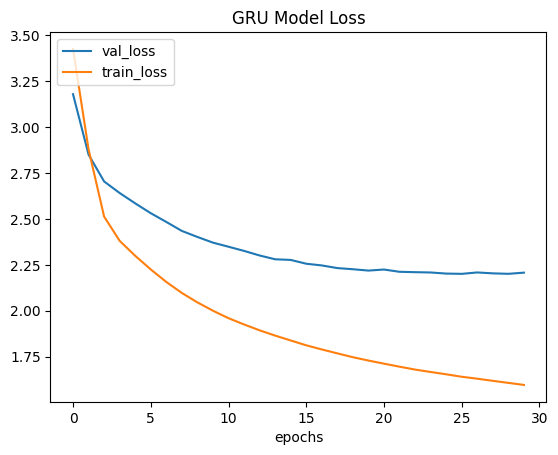

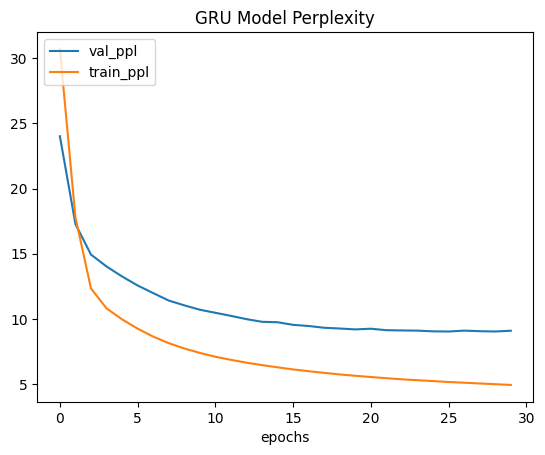

 and the Morlocks of the surpent of the surpent of

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please rea

2023-03-29 17:47:11.934486: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 17:47:11.934789: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-03-29 17:47:11.934865: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-29 17:47:11.935078: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 17:47:11.935394: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 17:47:11.935680: I tensorflow/compiler/x

In [5]:
# Train the gru model
batch_size = 2048
epochs = 30
num_states = 64
gru(num_states, batch_size, epochs)

Epoch 1/30
78/78 [==============================] - 6s 59ms/step - loss: 3.3598 - accuracy: 0.1520 - val_loss: 3.1813 - val_accuracy: 0.1574
Epoch 2/30
78/78 [==============================] - 4s 50ms/step - loss: 2.8812 - accuracy: 0.2120 - val_loss: 2.8399 - val_accuracy: 0.2641
Epoch 3/30
78/78 [==============================] - 4s 50ms/step - loss: 2.4789 - accuracy: 0.3043 - val_loss: 2.6884 - val_accuracy: 0.2845
Epoch 4/30
78/78 [==============================] - 4s 50ms/step - loss: 2.3428 - accuracy: 0.3252 - val_loss: 2.6060 - val_accuracy: 0.3053
Epoch 5/30
78/78 [==============================] - 4s 50ms/step - loss: 2.2477 - accuracy: 0.3463 - val_loss: 2.5397 - val_accuracy: 0.3241
Epoch 6/30
78/78 [==============================] - 4s 50ms/step - loss: 2.1676 - accuracy: 0.3674 - val_loss: 2.4739 - val_accuracy: 0.3351
Epoch 7/30
78/78 [==============================] - 4s 50ms/step - loss: 2.0935 - accuracy: 0.3857 - val_loss: 2.4141 - val_accuracy: 0.3544
Epoch 8/30
78

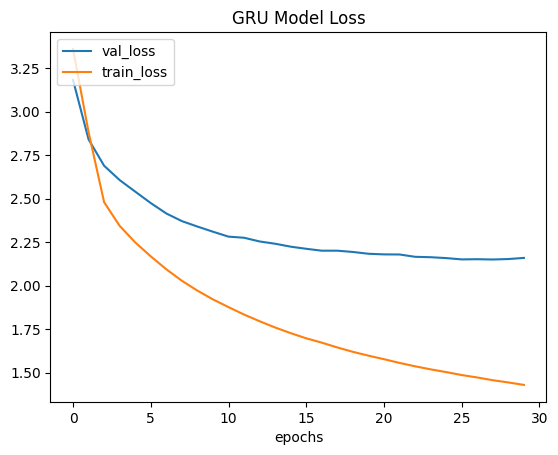

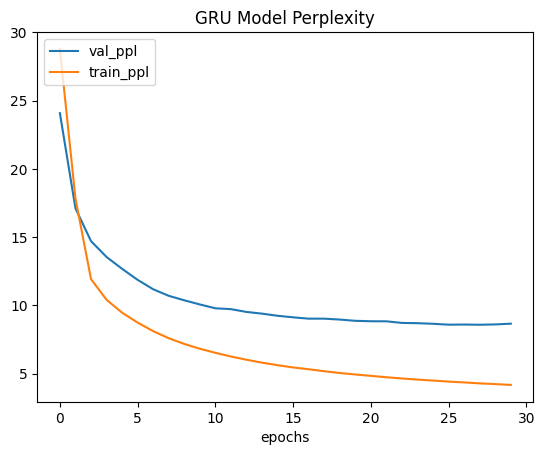

 the Time Travelled and the Time Travelled and the

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please rea

2023-03-29 17:49:29.218653: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 17:49:29.218946: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-03-29 17:49:29.219020: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-29 17:49:29.219225: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 17:49:29.219517: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 17:49:29.219796: I tensorflow/compiler/x

In [6]:
# Train the gru model
batch_size = 2048
epochs = 30
num_states = 128
gru(num_states, batch_size, epochs)

Epoch 1/30
78/78 [==============================] - 12s 137ms/step - loss: 3.3152 - accuracy: 0.1488 - val_loss: 3.1923 - val_accuracy: 0.1574
Epoch 2/30
78/78 [==============================] - 10s 132ms/step - loss: 2.8599 - accuracy: 0.2214 - val_loss: 2.8152 - val_accuracy: 0.2658
Epoch 3/30
78/78 [==============================] - 10s 133ms/step - loss: 2.4470 - accuracy: 0.3062 - val_loss: 2.6328 - val_accuracy: 0.2964
Epoch 4/30
78/78 [==============================] - 10s 134ms/step - loss: 2.2873 - accuracy: 0.3367 - val_loss: 2.5460 - val_accuracy: 0.3121
Epoch 5/30
78/78 [==============================] - 10s 134ms/step - loss: 2.1870 - accuracy: 0.3600 - val_loss: 2.4748 - val_accuracy: 0.3260
Epoch 6/30
78/78 [==============================] - 10s 135ms/step - loss: 2.1007 - accuracy: 0.3811 - val_loss: 2.4204 - val_accuracy: 0.3481
Epoch 7/30
78/78 [==============================] - 11s 135ms/step - loss: 2.0227 - accuracy: 0.4057 - val_loss: 2.3790 - val_accuracy: 0.3573

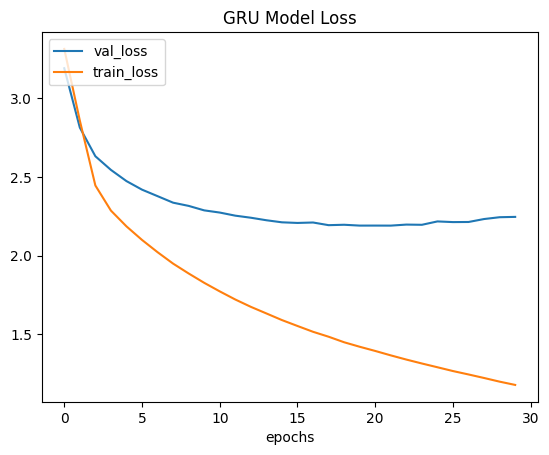

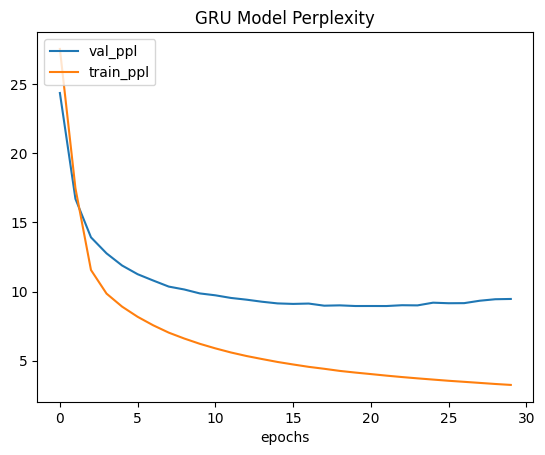

 got the still I stood we said I saw the still I s

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please rea

2023-03-29 17:55:47.026570: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 17:55:47.026849: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-03-29 17:55:47.026916: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-29 17:55:47.027153: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 17:55:47.027431: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 17:55:47.027691: I tensorflow/compiler/x

In [7]:
# Train the gru model
batch_size = 2048
epochs = 30
num_states = 256
gru(num_states, batch_size, epochs)

1b) Use the LSTM example, adjust the hyperparameters (fully connected network and the number of hidden states) and analyze their influence on running time, perplexity, training and validation loss, and the output sequence (try a few examples)

In [8]:
def lstm(num_states, batch_size, epochs):
    # Define the LSTM model
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(len(chars), 32),
        tf.keras.layers.LSTM(num_states),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(len(chars), activation='sigmoid')
    ])

    # Compile the model
    model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  metrics=["accuracy"])    
    # Train the model
    history = model.fit(
        np.array([x[0] for x in train_data]),
        np.array([x[1] for x in train_data]),
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(
            np.array([x[0] for x in val_data]),
            np.array([x[1] for x in val_data])))
    
    #Plotting Train and Val loss
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['loss'])
    plt.title('LSTM Model Loss')
    plt.xlabel('epochs')
    plt.legend(['val_loss', 'train_loss'], loc = 'upper left')
    plt.show()
    
    #Plotting Train, Val Perplexity
    plt.plot(tf.exp(history.history['val_loss']))
    plt.plot(tf.exp(history.history['loss']))
    plt.title('LSTM Model Perplexity')
    plt.xlabel('epochs')
    plt.legend(['val_ppl', 'train_ppl'], loc = 'upper left')
    plt.show()
    
    # Generate text using the trained model
    generated_text = ""
    seed = "It has"
    sequence = []
    for char in seed:
        sequence = sequence + [char_to_int[char]]
    print(sequence)
    for i in range(50):
        x = np.reshape(sequence, (1, len(sequence)))
        prediction = model.predict(x, verbose=0)
        index = np.argmax(prediction)
        result = int_to_char[index]
        generated_text += result
        sequence = np.append(sequence[1:], index)

    print(generated_text)
        
    #Getting Model Complexity and size
    flops = get_flops(model, batch_size=1)
    print(f"FLOPS: {flops / 10 ** 9:.03} G")
    model.summary()

Epoch 1/30
78/78 [==============================] - 4s 31ms/step - loss: 3.4379 - accuracy: 0.1628 - val_loss: 3.2295 - val_accuracy: 0.1574
Epoch 2/30
78/78 [==============================] - 1s 18ms/step - loss: 3.0669 - accuracy: 0.1650 - val_loss: 3.2196 - val_accuracy: 0.1574
Epoch 3/30
78/78 [==============================] - 1s 19ms/step - loss: 3.0086 - accuracy: 0.1728 - val_loss: 3.0811 - val_accuracy: 0.1964
Epoch 4/30
78/78 [==============================] - 1s 18ms/step - loss: 2.8141 - accuracy: 0.2218 - val_loss: 2.9890 - val_accuracy: 0.2319
Epoch 5/30
78/78 [==============================] - 1s 18ms/step - loss: 2.6482 - accuracy: 0.2770 - val_loss: 2.8252 - val_accuracy: 0.2715
Epoch 6/30
78/78 [==============================] - 1s 18ms/step - loss: 2.5079 - accuracy: 0.3032 - val_loss: 2.7317 - val_accuracy: 0.2838
Epoch 7/30
78/78 [==============================] - 1s 18ms/step - loss: 2.4221 - accuracy: 0.3170 - val_loss: 2.6743 - val_accuracy: 0.2879
Epoch 8/30
78

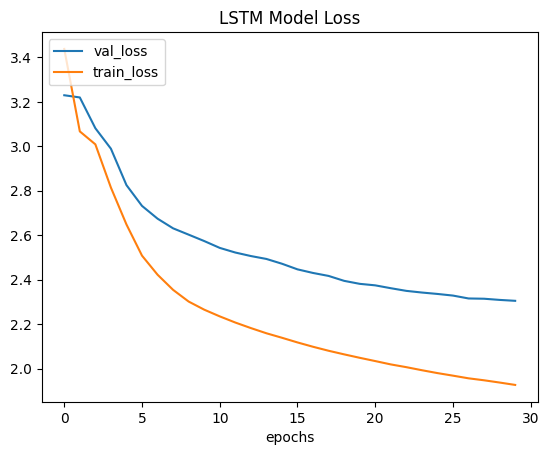

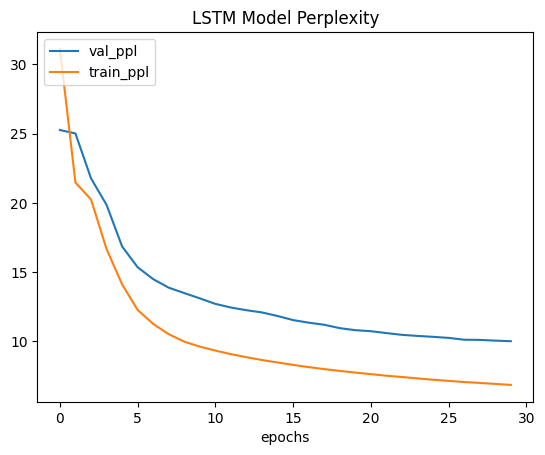

[36, 75, 1, 63, 56, 74]
 the sare don.





































=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float oper

2023-03-29 17:56:57.893247: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 17:56:57.893533: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-03-29 17:56:57.893606: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-29 17:56:57.893812: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 17:56:57.894095: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 17:56:57.894367: I tensorflow/compiler/x

In [9]:
# Train the LSTM model
batch_size = 2048
epochs = 30
num_states = 32
lstm(num_states, batch_size, epochs)

Epoch 1/30
78/78 [==============================] - 5s 43ms/step - loss: 3.3657 - accuracy: 0.1548 - val_loss: 3.2286 - val_accuracy: 0.1574
Epoch 2/30
78/78 [==============================] - 2s 29ms/step - loss: 3.0584 - accuracy: 0.1650 - val_loss: 3.1857 - val_accuracy: 0.1574
Epoch 3/30
78/78 [==============================] - 2s 27ms/step - loss: 2.8684 - accuracy: 0.2089 - val_loss: 2.9351 - val_accuracy: 0.2429
Epoch 4/30
78/78 [==============================] - 2s 28ms/step - loss: 2.5939 - accuracy: 0.2768 - val_loss: 2.8271 - val_accuracy: 0.2602
Epoch 5/30
78/78 [==============================] - 2s 27ms/step - loss: 2.4846 - accuracy: 0.2958 - val_loss: 2.7534 - val_accuracy: 0.2779
Epoch 6/30
78/78 [==============================] - 2s 27ms/step - loss: 2.3868 - accuracy: 0.3176 - val_loss: 2.6811 - val_accuracy: 0.3021
Epoch 7/30
78/78 [==============================] - 2s 27ms/step - loss: 2.3118 - accuracy: 0.3375 - val_loss: 2.6366 - val_accuracy: 0.3069
Epoch 8/30
78

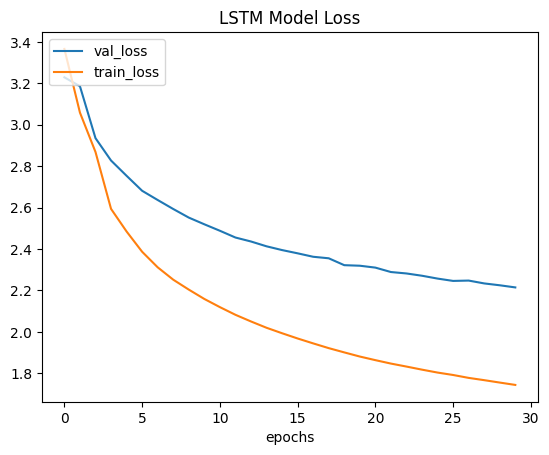

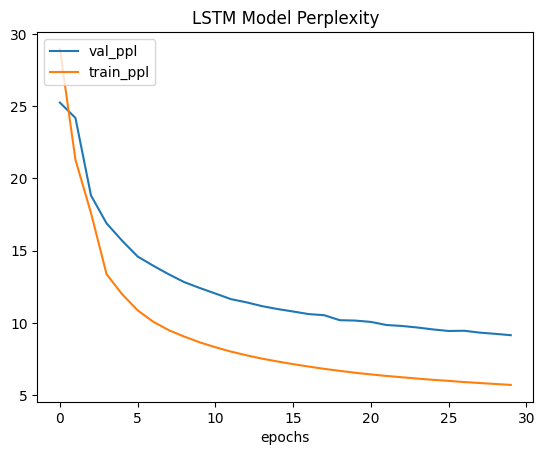

[36, 75, 1, 63, 56, 74]
 she Theine Theine Theine Theine Theine Theine The

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float oper

2023-03-29 18:01:48.213199: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 18:01:48.213496: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-03-29 18:01:48.213560: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-29 18:01:48.213853: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 18:01:48.214141: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 18:01:48.214413: I tensorflow/compiler/x

In [12]:
# Train the LSTM model
batch_size = 2048
epochs = 30
num_states = 64
lstm(num_states, batch_size, epochs)

Epoch 1/30
78/78 [==============================] - 7s 72ms/step - loss: 3.2755 - accuracy: 0.1605 - val_loss: 3.2265 - val_accuracy: 0.1574
Epoch 2/30
78/78 [==============================] - 5s 62ms/step - loss: 2.9940 - accuracy: 0.1809 - val_loss: 3.0689 - val_accuracy: 0.2106
Epoch 3/30
78/78 [==============================] - 5s 62ms/step - loss: 2.7241 - accuracy: 0.2638 - val_loss: 2.8546 - val_accuracy: 0.2643
Epoch 4/30
78/78 [==============================] - 5s 61ms/step - loss: 2.5201 - accuracy: 0.2945 - val_loss: 2.7826 - val_accuracy: 0.2718
Epoch 5/30
78/78 [==============================] - 5s 62ms/step - loss: 2.4285 - accuracy: 0.3087 - val_loss: 2.7287 - val_accuracy: 0.2906
Epoch 6/30
78/78 [==============================] - 5s 62ms/step - loss: 2.3547 - accuracy: 0.3240 - val_loss: 2.6904 - val_accuracy: 0.3030
Epoch 7/30
78/78 [==============================] - 5s 62ms/step - loss: 2.2932 - accuracy: 0.3391 - val_loss: 2.6610 - val_accuracy: 0.3095
Epoch 8/30
78

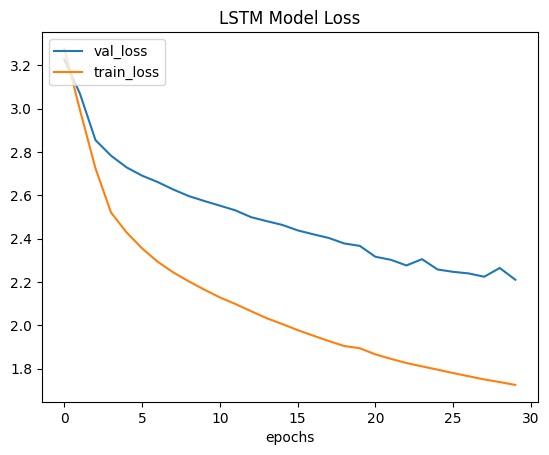

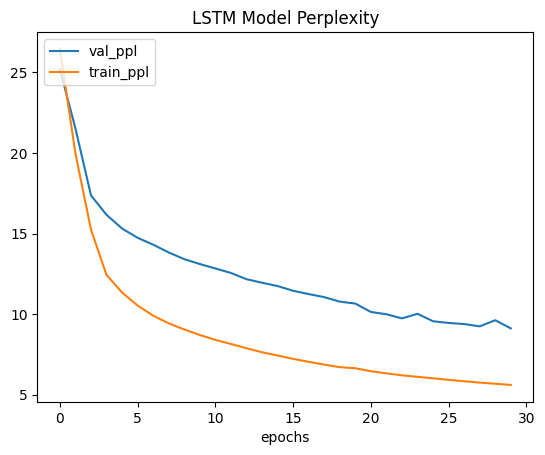

[36, 75, 1, 63, 56, 74]
 a sto the Time a sto the Time a sto the Time a st

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float oper

2023-03-29 18:04:30.232535: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 18:04:30.232830: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-03-29 18:04:30.232903: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-29 18:04:30.233125: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 18:04:30.233458: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 18:04:30.233726: I tensorflow/compiler/x

In [13]:
# Train the LSTM model
batch_size = 2048
epochs = 30
num_states = 128
lstm(num_states, batch_size, epochs)

Epoch 1/30
78/78 [==============================] - 14s 160ms/step - loss: 3.2247 - accuracy: 0.1603 - val_loss: 3.2240 - val_accuracy: 0.1574
Epoch 2/30
78/78 [==============================] - 12s 155ms/step - loss: 2.9644 - accuracy: 0.1927 - val_loss: 3.0063 - val_accuracy: 0.2489
Epoch 3/30
78/78 [==============================] - 12s 155ms/step - loss: 2.6065 - accuracy: 0.2896 - val_loss: 2.7807 - val_accuracy: 0.2735
Epoch 4/30
78/78 [==============================] - 12s 156ms/step - loss: 2.4358 - accuracy: 0.3079 - val_loss: 2.6977 - val_accuracy: 0.2887
Epoch 5/30
78/78 [==============================] - 12s 156ms/step - loss: 2.3373 - accuracy: 0.3302 - val_loss: 2.6475 - val_accuracy: 0.3171
Epoch 6/30
78/78 [==============================] - 12s 156ms/step - loss: 2.2487 - accuracy: 0.3468 - val_loss: 2.5988 - val_accuracy: 0.3261
Epoch 7/30
78/78 [==============================] - 12s 156ms/step - loss: 2.1763 - accuracy: 0.3632 - val_loss: 2.5605 - val_accuracy: 0.3293

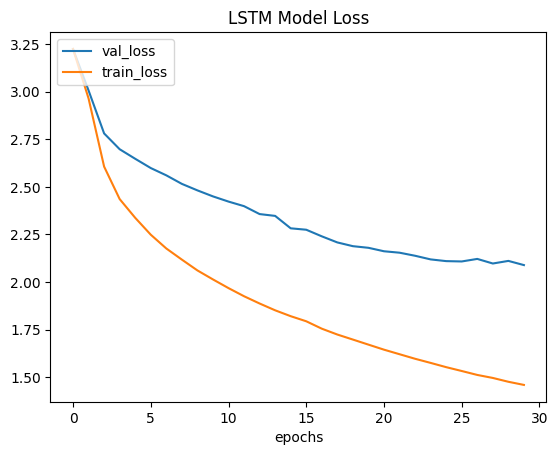

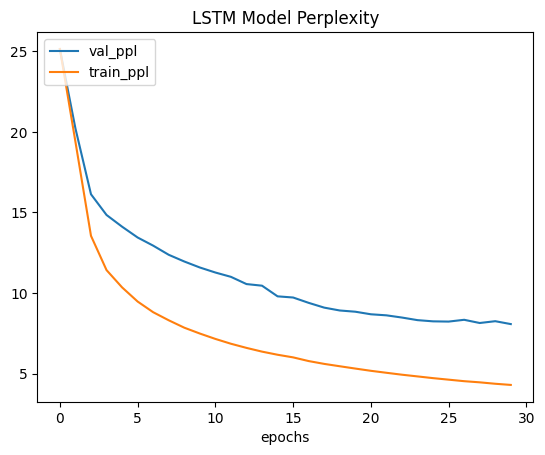

[36, 75, 1, 63, 56, 74]
t ary The where should onld the was she was she wa

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float oper

2023-03-29 18:10:41.879619: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 18:10:41.879924: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-03-29 18:10:41.880017: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-29 18:10:41.880329: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 18:10:41.881142: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 18:10:41.881462: I tensorflow/compiler/x

In [14]:
# Train the LSTM model
batch_size = 2048
epochs = 30
num_states = 256
lstm(num_states, batch_size, epochs)

1c) Compare runtime for training and inference, computational and mode size complexities, training and validation loss, and the output sequence (try a few examples)for rnn.RNN, rnn.LSTM and rnn.GRU implementations with each other use the same hyperparameters for your comparison. 

In [26]:
'''My simple RNN model'''
def rnn(num_states, batch_size, epochs):
    # Define the Simple RNN model
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(len(chars), 32),
        tf.keras.layers.SimpleRNN(num_states),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(len(chars), activation='sigmoid')
    ])

    # Compile the model
    model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  metrics=["accuracy"]) 
    
    # Train the model
    history = model.fit(
        np.array([x[0] for x in train_data]),
        np.array([x[1] for x in train_data]),
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(
            np.array([x[0] for x in val_data]),
            np.array([x[1] for x in val_data])))
    
    #Plotting Train and Val loss
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['loss'])
    plt.title('RNN Model Loss')
    plt.xlabel('epochs')
    plt.legend(['val_loss', 'train_loss'], loc = 'upper left')
    plt.show()
    
    #Plotting Train, Val Perplexity
    plt.plot(tf.exp(history.history['val_loss']))
    plt.plot(tf.exp(history.history['loss']))
    plt.title('RNN Model Perplexity')
    plt.xlabel('epochs')
    plt.legend(['val_ppl', 'train_ppl'], loc = 'upper left')
    plt.show()
    
    # Generate text using the trained model
    generated_text = ""
    seed = "It has" #Seed to give to model to precit the next 50 characters
    sequence = []
    for char in seed:
        sequence = sequence + [char_to_int[char]]
    print(sequence)
    for i in range(50):
        x = np.reshape(sequence, (1, len(sequence)))
        prediction = model.predict(x, verbose=0)
        index = np.argmax(prediction)
        result = int_to_char[index]
        generated_text += result
        sequence = np.append(sequence[1:], index)

    print(generated_text)
    #Getting Model Complexity and size
    flops = get_flops(model, batch_size=1)
    print(f"FLOPS: {flops / 10 ** 9:.03} G")
    model.summary()

Epoch 1/30
78/78 [==============================] - 7s 75ms/step - loss: 3.2926 - accuracy: 0.1595 - val_loss: 3.1942 - val_accuracy: 0.1574
Epoch 2/30
78/78 [==============================] - 5s 58ms/step - loss: 2.8565 - accuracy: 0.2213 - val_loss: 2.9095 - val_accuracy: 0.2523
Epoch 3/30
78/78 [==============================] - 5s 63ms/step - loss: 2.5531 - accuracy: 0.2849 - val_loss: 2.7757 - val_accuracy: 0.2719
Epoch 4/30
78/78 [==============================] - 5s 68ms/step - loss: 2.4270 - accuracy: 0.3153 - val_loss: 2.6905 - val_accuracy: 0.2965
Epoch 5/30
78/78 [==============================] - 5s 66ms/step - loss: 2.3283 - accuracy: 0.3339 - val_loss: 2.6406 - val_accuracy: 0.3106
Epoch 6/30
78/78 [==============================] - 5s 59ms/step - loss: 2.2600 - accuracy: 0.3477 - val_loss: 2.6066 - val_accuracy: 0.3252
Epoch 7/30
78/78 [==============================] - 4s 57ms/step - loss: 2.2142 - accuracy: 0.3589 - val_loss: 2.6055 - val_accuracy: 0.3190
Epoch 8/30
78

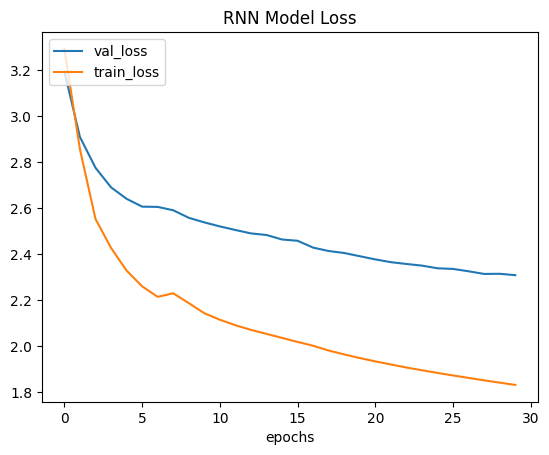

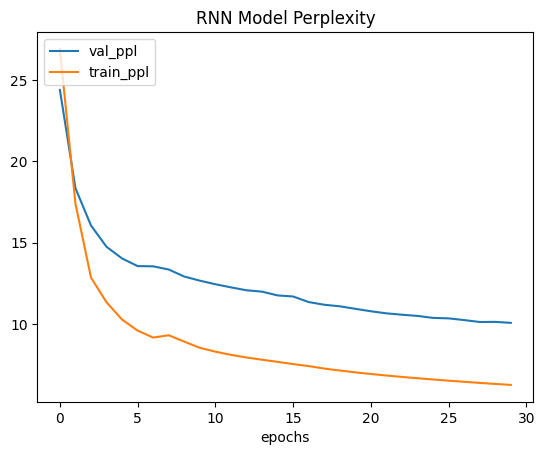

[36, 75, 1, 63, 56, 74]
 the stand the Time Travely the Time Travely the T

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float oper

2023-03-29 18:35:33.768708: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 18:35:33.768965: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-03-29 18:35:33.769028: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-29 18:35:33.769262: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 18:35:33.769545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 18:35:33.769792: I tensorflow/compiler/x

In [27]:
# Train the Simple RNN model
batch_size = 2048
epochs = 30
num_states = 32
rnn(num_states, batch_size, epochs)

Epoch 1/30
78/78 [==============================] - 7s 74ms/step - loss: 3.2584 - accuracy: 0.1586 - val_loss: 3.2013 - val_accuracy: 0.1574
Epoch 2/30
78/78 [==============================] - 5s 58ms/step - loss: 2.8260 - accuracy: 0.2272 - val_loss: 2.7863 - val_accuracy: 0.2656
Epoch 3/30
78/78 [==============================] - 5s 59ms/step - loss: 2.4183 - accuracy: 0.3166 - val_loss: 2.6391 - val_accuracy: 0.3068
Epoch 4/30
78/78 [==============================] - 5s 58ms/step - loss: 2.2811 - accuracy: 0.3456 - val_loss: 2.5718 - val_accuracy: 0.3261
Epoch 5/30
78/78 [==============================] - 5s 61ms/step - loss: 2.1893 - accuracy: 0.3665 - val_loss: 2.5236 - val_accuracy: 0.3348
Epoch 6/30
78/78 [==============================] - 4s 56ms/step - loss: 2.1186 - accuracy: 0.3843 - val_loss: 2.4922 - val_accuracy: 0.3454
Epoch 7/30
78/78 [==============================] - 4s 55ms/step - loss: 2.0642 - accuracy: 0.3971 - val_loss: 2.4553 - val_accuracy: 0.3599
Epoch 8/30
78

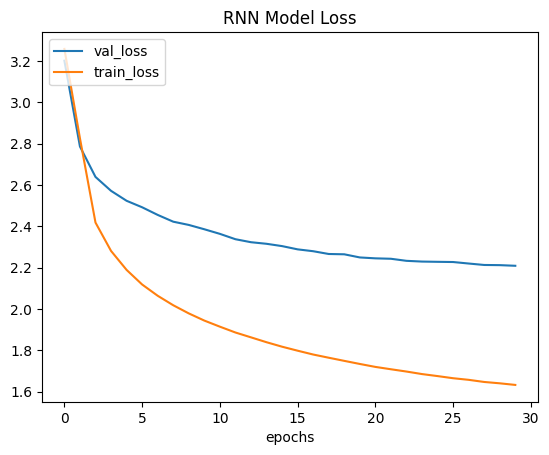

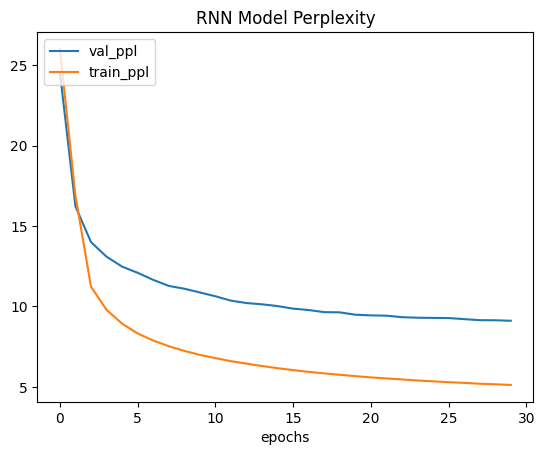

[36, 75, 1, 63, 56, 74]
 a mine was and I was and I was and I was and I wa

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float oper

2023-03-29 18:37:56.197599: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 18:37:56.198318: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-03-29 18:37:56.198418: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-29 18:37:56.198800: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 18:37:56.199063: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 18:37:56.199306: I tensorflow/compiler/x

In [28]:
# Train the Simple RNN model
batch_size = 2048
epochs = 30
num_states = 64
rnn(num_states, batch_size, epochs)

Epoch 1/30
78/78 [==============================] - 7s 73ms/step - loss: 3.2591 - accuracy: 0.1526 - val_loss: 3.2009 - val_accuracy: 0.1574
Epoch 2/30
78/78 [==============================] - 4s 57ms/step - loss: 2.8558 - accuracy: 0.2340 - val_loss: 2.8577 - val_accuracy: 0.2650
Epoch 3/30
78/78 [==============================] - 4s 54ms/step - loss: 2.4668 - accuracy: 0.3087 - val_loss: 2.6780 - val_accuracy: 0.2991
Epoch 4/30
78/78 [==============================] - 5s 59ms/step - loss: 2.3135 - accuracy: 0.3402 - val_loss: 2.5942 - val_accuracy: 0.3134
Epoch 5/30
78/78 [==============================] - 4s 52ms/step - loss: 2.2058 - accuracy: 0.3615 - val_loss: 2.5362 - val_accuracy: 0.3290
Epoch 6/30
78/78 [==============================] - 4s 54ms/step - loss: 2.1236 - accuracy: 0.3828 - val_loss: 2.4758 - val_accuracy: 0.3460
Epoch 7/30
78/78 [==============================] - 5s 59ms/step - loss: 2.0587 - accuracy: 0.4009 - val_loss: 2.4366 - val_accuracy: 0.3603
Epoch 8/30
78

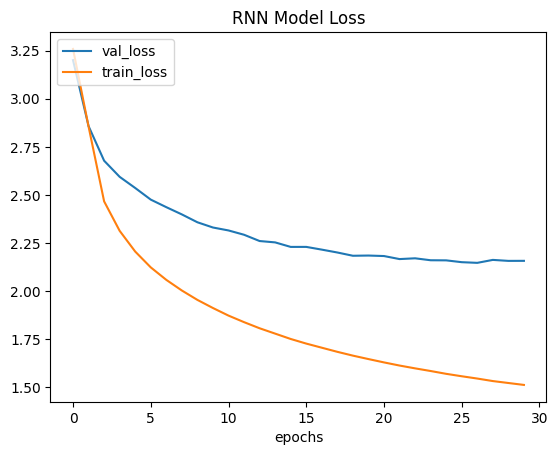

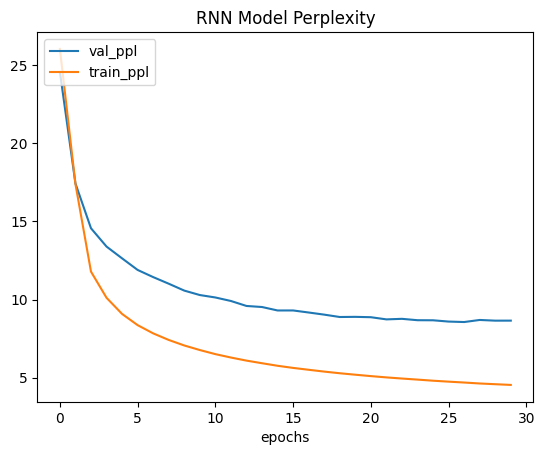

[36, 75, 1, 63, 56, 74]
 I saw the Time Traveller satches were I saw the T

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float oper

2023-03-29 18:40:16.417577: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 18:40:16.417851: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-03-29 18:40:16.417921: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-29 18:40:16.418117: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 18:40:16.418393: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 18:40:16.418655: I tensorflow/compiler/x

In [29]:
# Train the Simple RNN model
batch_size = 2048
epochs = 30
num_states = 128
rnn(num_states, batch_size, epochs)

Epoch 1/30
78/78 [==============================] - 8s 84ms/step - loss: 3.1597 - accuracy: 0.1604 - val_loss: 3.1381 - val_accuracy: 0.1846
Epoch 2/30
78/78 [==============================] - 6s 71ms/step - loss: 2.6478 - accuracy: 0.2811 - val_loss: 2.7342 - val_accuracy: 0.2822
Epoch 3/30
78/78 [==============================] - 6s 71ms/step - loss: 2.3645 - accuracy: 0.3265 - val_loss: 2.6147 - val_accuracy: 0.3138
Epoch 4/30
78/78 [==============================] - 6s 71ms/step - loss: 2.2234 - accuracy: 0.3561 - val_loss: 2.5425 - val_accuracy: 0.3290
Epoch 5/30
78/78 [==============================] - 6s 73ms/step - loss: 2.1112 - accuracy: 0.3855 - val_loss: 2.4934 - val_accuracy: 0.3504
Epoch 6/30
78/78 [==============================] - 6s 72ms/step - loss: 2.0298 - accuracy: 0.4068 - val_loss: 2.4586 - val_accuracy: 0.3603
Epoch 7/30
78/78 [==============================] - 6s 71ms/step - loss: 1.9636 - accuracy: 0.4268 - val_loss: 2.4126 - val_accuracy: 0.3707
Epoch 8/30
78

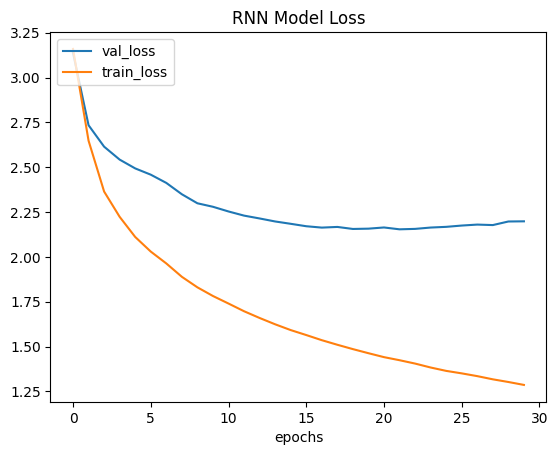

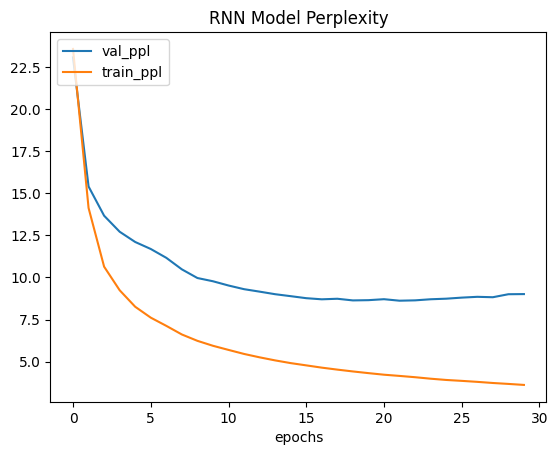

[36, 75, 1, 63, 56, 74]
 along the last as I saw a light the Time Travelle

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float oper

2023-03-29 18:43:11.419495: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 18:43:11.419797: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-03-29 18:43:11.419878: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-29 18:43:11.420144: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 18:43:11.420468: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 18:43:11.420753: I tensorflow/compiler/x

In [30]:
# Train the Simple RNN model
batch_size = 2048
epochs = 30
num_states = 256
rnn(num_states, batch_size, epochs)

2a) Build the model by replacing the GRU with an LSTM and compare the training and validation loss, and the output sequence (try a few examples) against GRU.
2b) Compare runtime for training and inference, computational and mode size complexities, and the output strings for nn.LSTM and rnn.GRU implementations with each other.
2c) Adjust the hyperparameters (fully connected network, number of hidden layers, and the number of hidden states) and compare your results (training and validation loss, computation complexity, model size, training and inference time, and the output sequence). Analyze their influence on accuracy, running time, and computational perplexity.

In [45]:
"""Deep LSTM RNN Model"""
def DeepLSTM(num_layers, batch_size, epochs):
    lstm_cells = [tf.keras.layers.LSTMCell(32) for _ in range(num_layers)]
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(len(chars), 32),
        tf.keras.layers.RNN(lstm_cells),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(len(chars), activation='sigmoid')
    ])

    # Compile the model
    model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
                  metrics=["accuracy"]) 
    # Train the model
    history = model.fit(
        np.array([x[0] for x in train_data]),
        np.array([x[1] for x in train_data]),
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(
            np.array([x[0] for x in val_data]),
            np.array([x[1] for x in val_data])))
    
    #Plotting Train and Val loss
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['loss'])
    plt.title('Deep LSTM Model Loss')
    plt.xlabel('epochs')
    plt.legend(['val_loss', 'train_loss'], loc = 'upper left')
    plt.show()
    
    #Plotting Train, Val Perplexity
    plt.plot(tf.exp(history.history['val_loss']))
    plt.plot(tf.exp(history.history['loss']))
    plt.title('Deep LSTM Model Perplexity')
    plt.xlabel('epochs')
    plt.legend(['val_ppl', 'train_ppl'], loc = 'upper left')
    plt.show()
    
    # Generate text using the trained model
    generated_text = ""
    seed = "It has" #Seed to give to model to precit the next 50 characters
    sequence = []
    for char in seed:
        sequence = sequence + [char_to_int[char]]
    print(sequence)
    for i in range(50):
        x = np.reshape(sequence, (1, len(sequence)))
        prediction = model.predict(x, verbose=0)
        index = np.argmax(prediction)
        result = int_to_char[index]
        generated_text += result
        sequence = np.append(sequence[1:], index)

    print(generated_text)
    
    #Getting Model Complexity and size
    flops = get_flops(model, batch_size=1)
    print(f"FLOPS: {flops / 10 ** 9:.03} G")
    model.summary()

Epoch 1/30
78/78 [==============================] - 19s 209ms/step - loss: 3.1082 - accuracy: 0.1640 - val_loss: 3.1023 - val_accuracy: 0.1868
Epoch 2/30
78/78 [==============================] - 17s 216ms/step - loss: 2.6204 - accuracy: 0.2597 - val_loss: 2.7272 - val_accuracy: 0.2928
Epoch 3/30
78/78 [==============================] - 16s 201ms/step - loss: 2.3154 - accuracy: 0.3366 - val_loss: 2.6150 - val_accuracy: 0.3234
Epoch 4/30
78/78 [==============================] - 15s 195ms/step - loss: 2.1720 - accuracy: 0.3698 - val_loss: 2.5387 - val_accuracy: 0.3426
Epoch 5/30
78/78 [==============================] - 15s 193ms/step - loss: 2.0552 - accuracy: 0.4007 - val_loss: 2.4457 - val_accuracy: 0.3658
Epoch 6/30
78/78 [==============================] - 15s 196ms/step - loss: 1.9746 - accuracy: 0.4203 - val_loss: 2.3957 - val_accuracy: 0.3799
Epoch 7/30
78/78 [==============================] - 15s 195ms/step - loss: 1.9107 - accuracy: 0.4384 - val_loss: 2.3819 - val_accuracy: 0.3850

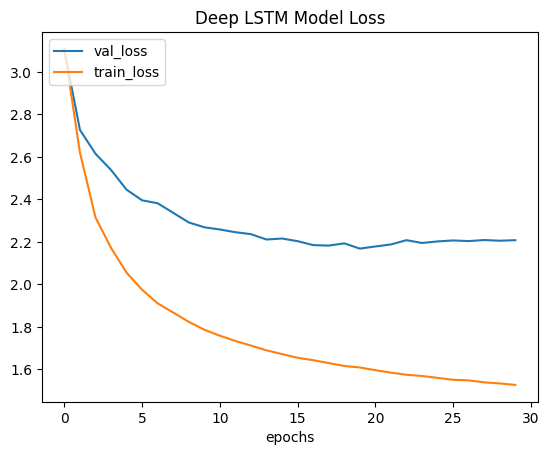

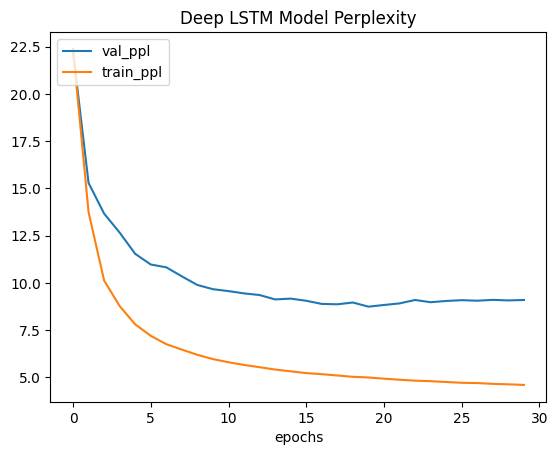

[36, 75, 1, 63, 56, 74]
 the Timing the Timing the Timing the Timing the T

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float oper

2023-03-29 19:15:39.939381: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 19:15:39.939630: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-03-29 19:15:39.939694: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-29 19:15:39.939990: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 19:15:39.940238: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 19:15:39.940471: I tensorflow/compiler/x

In [46]:
#Train Deep LSTM model with 2 layers
LSTM2 = DeepLSTM(2, 2048, 30)

Epoch 1/30
78/78 [==============================] - 24s 272ms/step - loss: 3.1472 - accuracy: 0.1595 - val_loss: 3.2322 - val_accuracy: 0.1574
Epoch 2/30
78/78 [==============================] - 21s 270ms/step - loss: 2.8335 - accuracy: 0.2065 - val_loss: 2.9059 - val_accuracy: 0.2458
Epoch 3/30
78/78 [==============================] - 22s 276ms/step - loss: 2.4556 - accuracy: 0.3002 - val_loss: 2.7125 - val_accuracy: 0.3070
Epoch 4/30
78/78 [==============================] - 22s 286ms/step - loss: 2.2793 - accuracy: 0.3461 - val_loss: 2.6464 - val_accuracy: 0.3251
Epoch 5/30
78/78 [==============================] - 22s 281ms/step - loss: 2.1616 - accuracy: 0.3728 - val_loss: 2.5893 - val_accuracy: 0.3415
Epoch 6/30
78/78 [==============================] - 20s 259ms/step - loss: 2.0733 - accuracy: 0.3936 - val_loss: 2.5368 - val_accuracy: 0.3582
Epoch 7/30
78/78 [==============================] - 23s 295ms/step - loss: 2.0072 - accuracy: 0.4097 - val_loss: 2.4879 - val_accuracy: 0.3710

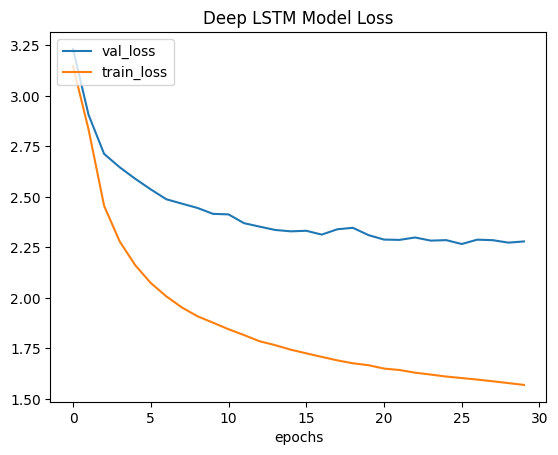

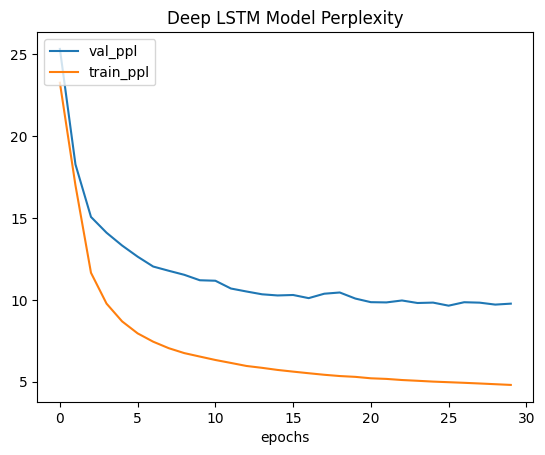

[36, 75, 1, 63, 56, 74]
 a strent and ther of the and ther of the and ther

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float oper

2023-03-29 19:28:06.229396: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 19:28:06.229647: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-03-29 19:28:06.229709: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-29 19:28:06.230015: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 19:28:06.230264: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 19:28:06.230499: I tensorflow/compiler/x

In [47]:
#Train Deep LSTM model with 3 layers
LSTM3 = DeepLSTM(3, 2048, 30)

Epoch 1/30
78/78 [==============================] - 38s 427ms/step - loss: 3.1489 - accuracy: 0.1590 - val_loss: 3.2331 - val_accuracy: 0.1574
Epoch 2/30
78/78 [==============================] - 31s 391ms/step - loss: 3.0768 - accuracy: 0.1650 - val_loss: 3.2372 - val_accuracy: 0.1574
Epoch 3/30
78/78 [==============================] - 31s 403ms/step - loss: 3.0124 - accuracy: 0.1730 - val_loss: 3.0625 - val_accuracy: 0.1773
Epoch 4/30
78/78 [==============================] - 29s 372ms/step - loss: 2.6477 - accuracy: 0.2500 - val_loss: 2.8343 - val_accuracy: 0.2659
Epoch 5/30
78/78 [==============================] - 28s 356ms/step - loss: 2.4134 - accuracy: 0.3067 - val_loss: 2.7349 - val_accuracy: 0.2930
Epoch 6/30
78/78 [==============================] - 29s 371ms/step - loss: 2.2772 - accuracy: 0.3430 - val_loss: 2.6515 - val_accuracy: 0.3199
Epoch 7/30
78/78 [==============================] - 28s 355ms/step - loss: 2.1856 - accuracy: 0.3655 - val_loss: 2.5954 - val_accuracy: 0.3335

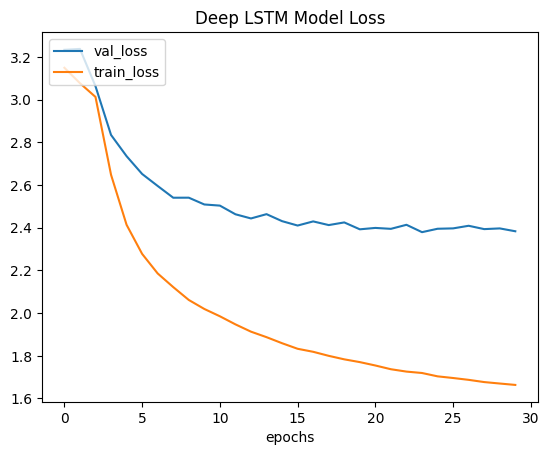

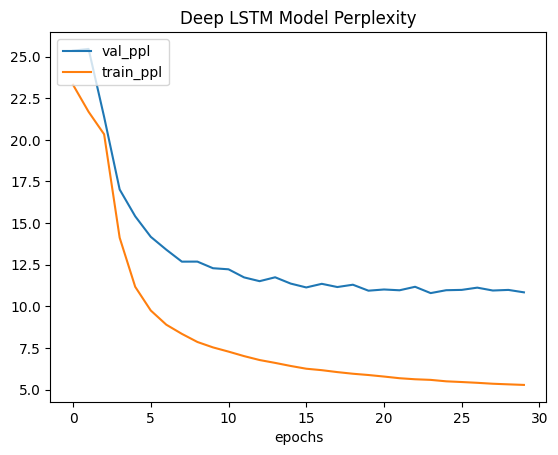

[36, 75, 1, 63, 56, 74]
 ann a seard a ston the stress and the Thepend and


2023-03-29 19:43:21.095689: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 19:43:21.095975: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-03-29 19:43:21.096082: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-29 19:43:21.096358: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 19:43:21.096600: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 19:43:21.096829: I tensorflow/compiler/x


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi

Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.


In [48]:
#Train Deep LSTM model with 4 layers
LSTM4 = DeepLSTM(4, 2048, 30)

In [52]:
"""Deep GRU RNN Model"""
def DeepGRU(num_layers, batch_size, epochs):
    gru_cells = [tf.keras.layers.GRUCell(32) for _ in range(num_layers)]
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(len(chars), 32),
        tf.keras.layers.RNN(gru_cells),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(len(chars), activation='sigmoid')
    ])

    # Compile the model
    model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
                  metrics=["accuracy"]) 
    
    # Train the model
    history = model.fit(
        np.array([x[0] for x in train_data]),
        np.array([x[1] for x in train_data]),
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(
            np.array([x[0] for x in val_data]),
            np.array([x[1] for x in val_data])))
    
    #Plotting Train and Val loss
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['loss'])
    plt.title('Deep GRU Model Loss')
    plt.xlabel('epochs')
    plt.legend(['val_loss', 'train_loss'], loc = 'upper left')
    plt.show()
    
    #Plotting Train, Val Perplexity
    plt.plot(tf.exp(history.history['val_loss']))
    plt.plot(tf.exp(history.history['loss']))
    plt.title('Deep GRU Model Perplexity')
    plt.xlabel('epochs')
    plt.legend(['val_ppl', 'train_ppl'], loc = 'upper left')
    plt.show()    
    
    # Generate text using the trained model
    generated_text = ""
    seed = "It has" #Seed to give to model to precit the next 50 characters
    sequence = []
    for char in seed:
        sequence = sequence + [char_to_int[char]]
    print(sequence)
    for i in range(50):
        x = np.reshape(sequence, (1, len(sequence)))
        prediction = model.predict(x, verbose=0)
        index = np.argmax(prediction)
        result = int_to_char[index]
        generated_text += result
        sequence = np.append(sequence[1:], index)

    print(generated_text)
    
    #Getting Model Complexity and size
    flops = get_flops(model, batch_size=1)
    print(f"FLOPS: {flops / 10 ** 9:.03} G")
    model.summary()

Epoch 1/30
78/78 [==============================] - 23s 259ms/step - loss: 2.8237 - accuracy: 0.2314 - val_loss: 2.6693 - val_accuracy: 0.3025
Epoch 2/30
78/78 [==============================] - 20s 262ms/step - loss: 2.1440 - accuracy: 0.3768 - val_loss: 2.4465 - val_accuracy: 0.3631
Epoch 3/30
78/78 [==============================] - 18s 237ms/step - loss: 1.9284 - accuracy: 0.4341 - val_loss: 2.3337 - val_accuracy: 0.3976
Epoch 4/30
78/78 [==============================] - 19s 243ms/step - loss: 1.8098 - accuracy: 0.4665 - val_loss: 2.2546 - val_accuracy: 0.4073
Epoch 5/30
78/78 [==============================] - 19s 240ms/step - loss: 1.7299 - accuracy: 0.4879 - val_loss: 2.2123 - val_accuracy: 0.4290
Epoch 6/30
78/78 [==============================] - 19s 243ms/step - loss: 1.6728 - accuracy: 0.5022 - val_loss: 2.1864 - val_accuracy: 0.4343
Epoch 7/30
78/78 [==============================] - 19s 240ms/step - loss: 1.6284 - accuracy: 0.5147 - val_loss: 2.1682 - val_accuracy: 0.4385

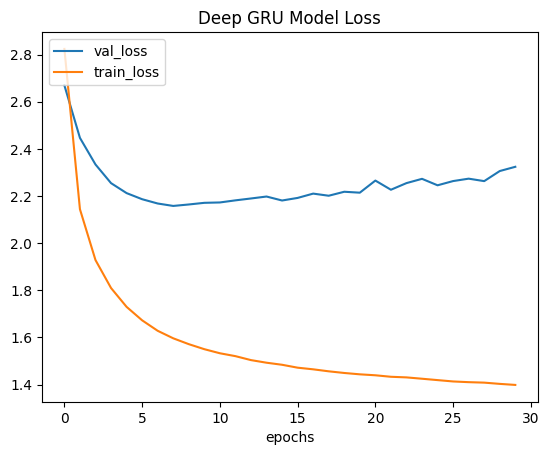

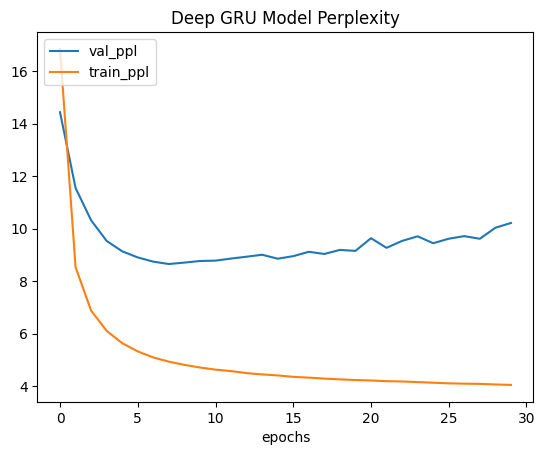

[36, 75, 1, 63, 56, 74]
 the satisface, and the satisface, and the satisfa

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float oper

2023-03-29 19:55:19.652741: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 19:55:19.652988: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-03-29 19:55:19.653059: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-29 19:55:19.653280: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 19:55:19.653532: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 19:55:19.653767: I tensorflow/compiler/x

In [53]:
#Train Deep GRU model with 2 layers
GRU2 = DeepGRU(2, 2048, 30)

Epoch 1/30
78/78 [==============================] - 34s 391ms/step - loss: 2.8911 - accuracy: 0.2177 - val_loss: 2.6980 - val_accuracy: 0.2920
Epoch 2/30
78/78 [==============================] - 29s 376ms/step - loss: 2.1977 - accuracy: 0.3615 - val_loss: 2.4550 - val_accuracy: 0.3536
Epoch 3/30
78/78 [==============================] - 30s 382ms/step - loss: 1.9816 - accuracy: 0.4166 - val_loss: 2.3437 - val_accuracy: 0.3925
Epoch 4/30
78/78 [==============================] - 29s 369ms/step - loss: 1.8477 - accuracy: 0.4539 - val_loss: 2.2801 - val_accuracy: 0.4126
Epoch 5/30
78/78 [==============================] - 29s 376ms/step - loss: 1.7588 - accuracy: 0.4787 - val_loss: 2.2405 - val_accuracy: 0.4243
Epoch 6/30
78/78 [==============================] - 30s 382ms/step - loss: 1.6976 - accuracy: 0.4952 - val_loss: 2.2169 - val_accuracy: 0.4247
Epoch 7/30
78/78 [==============================] - 28s 361ms/step - loss: 1.6495 - accuracy: 0.5090 - val_loss: 2.2161 - val_accuracy: 0.4432

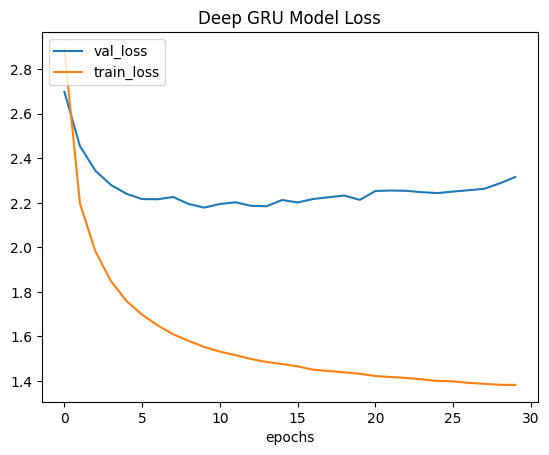

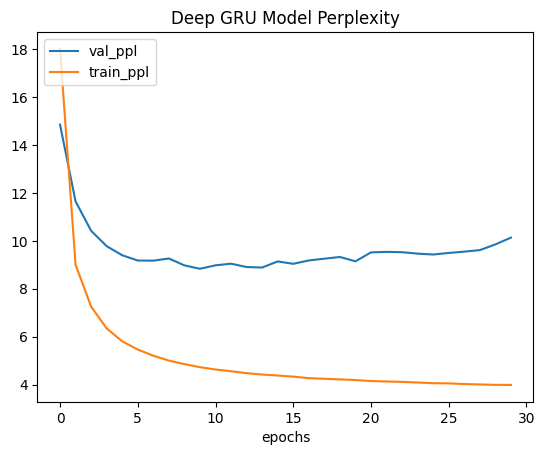

[36, 75, 1, 63, 56, 74]
 stood the same the same the same the same the sam

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float oper

2023-03-29 20:12:08.051602: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 20:12:08.052290: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-03-29 20:12:08.052377: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-29 20:12:08.052735: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 20:12:08.053382: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 20:12:08.053718: I tensorflow/compiler/x

In [54]:
#Train Deep GRU model with 3 layers
GRU3 = DeepGRU(3, 2048, 30)

Epoch 1/30
78/78 [==============================] - 41s 476ms/step - loss: 3.0579 - accuracy: 0.1758 - val_loss: 2.9449 - val_accuracy: 0.2344
Epoch 2/30
78/78 [==============================] - 39s 500ms/step - loss: 2.3712 - accuracy: 0.3189 - val_loss: 2.6057 - val_accuracy: 0.3172
Epoch 3/30
78/78 [==============================] - 38s 487ms/step - loss: 2.1521 - accuracy: 0.3692 - val_loss: 2.5197 - val_accuracy: 0.3476
Epoch 4/30
78/78 [==============================] - 39s 505ms/step - loss: 2.0358 - accuracy: 0.3992 - val_loss: 2.4612 - val_accuracy: 0.3664
Epoch 5/30
78/78 [==============================] - 40s 511ms/step - loss: 1.9441 - accuracy: 0.4254 - val_loss: 2.3961 - val_accuracy: 0.3866
Epoch 6/30
78/78 [==============================] - 39s 506ms/step - loss: 1.8788 - accuracy: 0.4447 - val_loss: 2.3982 - val_accuracy: 0.3960
Epoch 7/30
78/78 [==============================] - 39s 502ms/step - loss: 1.8209 - accuracy: 0.4601 - val_loss: 2.3484 - val_accuracy: 0.4069

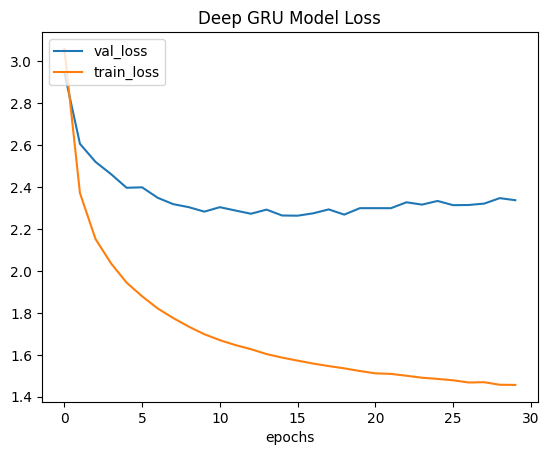

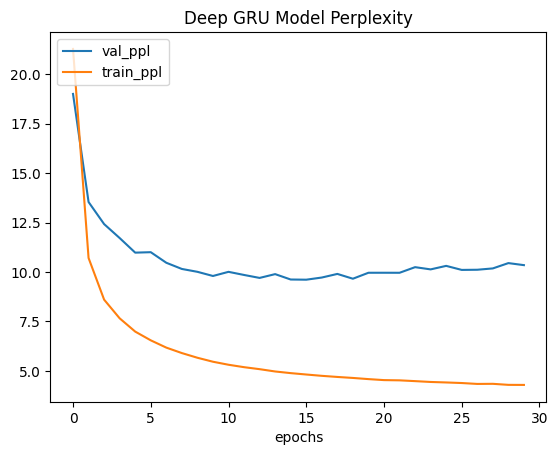

[36, 75, 1, 63, 56, 74]
tent the start the start the start the start the s


2023-03-29 20:32:31.320214: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 20:32:31.320470: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-03-29 20:32:31.320531: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-29 20:32:31.320860: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 20:32:31.321114: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 20:32:31.321347: I tensorflow/compiler/x


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi

Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.


In [55]:
#Train Deep GRU model with 4 layers
GRU4 = DeepGRU(4, 2048, 30)